This notebook checks how well a CatBoostRegressor model (single and multi output) classifies bulletins into F, M and N. It gets similar accuracy as the logistic regression accuracy model, but is worse when it comes to classifying bulletins with a majority of female applicants.

In [2]:
import os
os.chdir(r"c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox")

import gensim
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [4]:
df = pd.read_csv("data/cleaned_data/bulletins_labels_share_content.csv", dtype={'ID': object})  
df = df[["ID", "Job Description", "Apps Received", "Female", "Male", "Unknown_Gender", "Apps Received (unknown gender removed)", "Male share", "Female share", "Male share (unknown gender included)", "Female share (unknown gender included)", "Cleaned text"]]
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,Apps Received (unknown gender removed),Male share,Female share,Male share (unknown gender included),Female share (unknown gender included),Cleaned text
0,9206,311 DIRECTOR,54,20,31,3,51,0.608,0.392,0.574,0.370,director class code open date annual salary du...
1,1223,ACCOUNTING CLERK,648,488,152,8,640,0.238,0.762,0.235,0.753,accounting clerk class code open date exam ope...
2,7260,AIRPORT MANAGER,51,13,37,1,50,0.740,0.260,0.725,0.255,airport manager class code open date exam open...
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,47,0.809,0.191,0.792,0.188,airport police lieutenant class code open date...
4,2400,AQUARIST,40,15,24,1,39,0.615,0.385,0.600,0.375,aquarist class code open date annual salary ca...
...,...,...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,15,0.600,0.400,0.562,0.375,wastewater treatment laboratory manager class ...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,122,0.926,0.074,0.904,0.072,wastewater treatment operator class code open ...
174,7857,WATER MICROBIOLOGIST,179,89,82,8,171,0.480,0.520,0.458,0.497,water microbiologist class code open date revi...
175,3912,WATER UTILITY WORKER,96,2,92,2,94,0.979,0.021,0.958,0.021,water utility worker class code open date exam...


In [5]:
corpus = list(df["Cleaned text"])
google_model = gensim.models.KeyedVectors.load_word2vec_format("c:/Users/britt/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [6]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit_transform(corpus)

<177x3835 sparse matrix of type '<class 'numpy.float64'>'
	with 68003 stored elements in Compressed Sparse Row format>

In [7]:
vocabulary = tfidf_vectorizer.get_feature_names_out()
documents_embeddings = []
documents_scaled_embeddings = []
for doc in corpus:
    word_embeddings = []
    scaled_embeddings  = []
    doc_list = doc.split()
    for word in doc_list:
        if word in google_model.key_to_index.keys():
            embedding = google_model[word]
            word_embeddings.append(embedding)
            index = np.where(vocabulary == word)[0]
            try:
                scaled_embeddings.append(embedding * tfidf_vectorizer.idf_[index])
            except ValueError:
                pass
    documents_embeddings.append(word_embeddings)
    documents_scaled_embeddings.append(scaled_embeddings)

In [8]:
doc_vectors = [np.average(doc, axis=0) for doc in documents_embeddings]
X_embeddings = np.array(doc_vectors)
X_embeddings.shape

(177, 300)

In [31]:
scaled_doc_vectors = [np.average(doc, axis=0) for doc in documents_scaled_embeddings]
X_scaled_embeddings = np.array(scaled_doc_vectors)
X_scaled_embeddings.shape

(177, 300)

In [32]:
y = list(df["Male share"])
len(y)

177

In [33]:
X_scal_emb_train, X_scal_emb_test, y_scal_emb_train, y_scal_emb_test = train_test_split(X_scaled_embeddings, y, test_size=0.3, random_state=428)

In [8]:
X_emb_train, X_emb_test, y_emb_train, y_emb_test = train_test_split(X_embeddings, y, test_size=0.3, random_state=428)

In [34]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 0.02, step=0.001)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    #param['iterations'] = 10000
    #param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = 1
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_emb_train, y_emb_train, early_stopping_rounds=100)
    loss = mean_squared_error(y_emb_test, regressor.predict(X_emb_test), squared=False)
    return loss

In [35]:
study = optuna.create_study()
study.optimize(objective, n_trials=500)

[I 2023-01-16 12:18:43,398] A new study created in memory with name: no-name-a05e87ba-782f-4150-8b52-d6830e066602
[I 2023-01-16 12:19:01,860] Trial 0 finished with value: 0.15686296751139533 and parameters: {'learning_rate': 0.005, 'depth': 13, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 0 with value: 0.15686296751139533.
[I 2023-01-16 12:19:11,895] Trial 1 finished with value: 0.15783406547129683 and parameters: {'learning_rate': 0.015, 'depth': 12, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 0 with value: 0.15686296751139533.
[I 2023-01-16 12:19:16,312] Trial 2 finished with value: 0.20214280781777624 and parameters: {'learning_rate': 0.001, 'depth': 11, 'l2_leaf_reg': 2.5, 'min_child_samples': 32}. Best is trial 0 with value: 0.15686296751139533.
[I 2023-01-16 12:19:24,815] Trial 3 finished with value: 0.15172186355077102 and parameters: {'learning_rate': 0.016, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}. Best is trial 3 with value: 0.151

KeyboardInterrupt: 

In [34]:
param = {}
param['learning_rate'] = 0.013
param['depth'] = 9
param['l2_leaf_reg'] = 3.5
param['min_child_samples'] = 16
param['grow_policy'] = 'Depthwise'
param['eval_metric'] = 'RMSE'
param['od_type'] = 'iter'
param['od_wait'] = 20
param['random_state'] = 1
param['logging_level'] = 'Silent'

regressor = CatBoostRegressor(**param)

regressor.fit(X_scal_emb_train, y_scal_emb_train, early_stopping_rounds=100)

In [35]:
rmse = mean_squared_error(y_scal_emb_test, regressor.predict(X_scal_emb_test), squared=False)
mae = mean_absolute_error(y_scal_emb_test, regressor.predict(X_scal_emb_test))
r2 = r2_score(y_scal_emb_test, regressor.predict(X_scal_emb_test))

In [36]:
rmse

0.14943804485872178

In [37]:
mae

0.11648397938668947

In [38]:
r2

0.6556700840048342

In [39]:
male_share_predictions = regressor.predict(X_scal_emb_test)
male_share_predictions

array([0.54024736, 0.95864111, 0.93712577, 0.53939528, 0.48271451,
       0.77086703, 0.5614412 , 0.78828789, 0.98532072, 0.98780179,
       0.50164301, 0.81354601, 0.8407175 , 0.8591063 , 0.53246105,
       0.53213487, 0.65828917, 0.47058735, 0.79091306, 0.59905004,
       0.64039035, 0.77522427, 0.88949877, 0.9648554 , 0.59231098,
       0.68914654, 0.76381926, 0.60970925, 0.45225168, 0.49722023,
       0.60020931, 0.84615073, 0.90962451, 0.62169275, 0.50413828,
       0.79475337, 0.98761126, 0.77172235, 0.80316479, 0.6593616 ,
       0.52419651, 0.4250329 , 0.4097748 , 0.50948208, 0.7702241 ,
       0.87348461, 0.66912078, 0.93970962, 0.88753168, 0.76652459,
       0.5898881 , 0.64108785, 0.81001648, 0.5567871 ])

In [40]:
predicted_labels_cb = []
for share in male_share_predictions:
    if share < 0.3:
        label = "F"
    elif share < 0.7:
        label = "N"
    else:
        label = "M"
    predicted_labels_cb.append(label)

In [41]:
true_male_shares = y_scal_emb_test
true_male_shares

[0.235,
 0.996,
 0.984,
 0.27,
 0.625,
 0.897,
 0.6,
 0.826,
 0.99,
 1.0,
 0.385,
 0.911,
 0.95,
 1.0,
 0.358,
 0.486,
 0.4,
 0.5,
 0.883,
 0.929,
 0.916,
 0.846,
 0.96,
 0.931,
 0.585,
 0.692,
 0.846,
 0.475,
 0.293,
 0.073,
 0.824,
 0.8,
 0.968,
 0.426,
 0.629,
 0.978,
 0.968,
 0.763,
 0.941,
 0.429,
 0.596,
 0.409,
 0.409,
 0.422,
 0.75,
 1.0,
 0.893,
 1.0,
 1.0,
 0.56,
 0.492,
 0.508,
 0.931,
 0.664]

In [42]:
true_labels = []
for share in true_male_shares:
    if share < 0.3:
        label = "F"
    elif share < 0.7:
        label = "N"
    else:
        label = "M"
    true_labels.append(label)

In [43]:
correct = 0
for pred, true in zip(predicted_labels_cb, true_labels):
    if pred == true:
        correct += 1
correct / len(predicted_labels_cb)

0.8333333333333334

In [44]:
train_labels = []
for share in y_scal_emb_train:
    if share < 0.3:
        label = "F"
    elif share < 0.7:
        label = "N"
    else:
        label = "M"
    train_labels.append(label)

In [45]:
def objective(trial):
    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_emb_train, train_labels)

    return clf.score(X_emb_test, true_labels)

In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-16 15:21:00,775] A new study created in memory with name: no-name-1f3e3963-e075-40aa-9ec4-463a951b0e82
[I 2023-01-16 15:21:00,795] Trial 0 finished with value: 0.4074074074074074 and parameters: {'C': 1.537112897918408e-06, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.4074074074074074.
[I 2023-01-16 15:21:00,801] Trial 1 finished with value: 0.4074074074074074 and parameters: {'C': 3.3554144082397865e-07, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.4074074074074074.
[I 2023-01-16 15:21:00,836] Trial 2 finished with value: 0.5370370370370371 and parameters: {'C': 0.002790564597451832, 'c_weight': None}. Best is trial 2 with value: 0.5370370370370371.
[I 2023-01-16 15:21:00,842] Trial 3 finished with value: 0.4074074074074074 and parameters: {'C': 1.0523905110524565e-05, 'c_weight': 'balanced'}. Best is trial 2 with value: 0.5370370370370371.
[I 2023-01-16 15:21:00,851] Trial 4 finished with value: 0.7037037037037037 and parameters: {'C': 2.651541371541572

In [23]:
study.best_params

{'C': 5.405950772717123, 'c_weight': None}

In [46]:
clf = LogisticRegression(C=9.025495166169046, class_weight="balanced")
clf.fit(X_scal_emb_train, train_labels)

predicted_labels_lr = clf.predict(X_scal_emb_test)

In [47]:
acc = accuracy_score(predicted_labels_lr, true_labels)
recall = recall_score(predicted_labels_lr, true_labels, average="weighted")
precision = precision_score(predicted_labels_lr, true_labels, average="weighted")
f1 = f1_score(predicted_labels_lr, true_labels, average="weighted")

In [48]:
print("Classification with logistic regression model:")
print(f"Score: {round(acc, 3)}")
print(f"F1: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")

Classification with logistic regression model:
Score: 0.833
F1: 0.834
Recall: 0.833
Precision: 0.865


In [49]:
acc = accuracy_score(predicted_labels_cb, true_labels)
recall = recall_score(predicted_labels_cb, true_labels, average="weighted")
precision = precision_score(predicted_labels_cb, true_labels, average="weighted")
f1 = f1_score(predicted_labels_cb, true_labels, average="weighted")

c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
print("Classification by converting predicted shares from CatBoostRegressor to labels:")
print(f"Score: {round(acc, 3)}")
print(f"F1: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")

Classification by converting predicted shares from CatBoostRegressor to labels:
Score: 0.833
F1: 0.861
Recall: 0.833
Precision: 0.909


In [51]:
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels_lr, labels=clf.classes_)

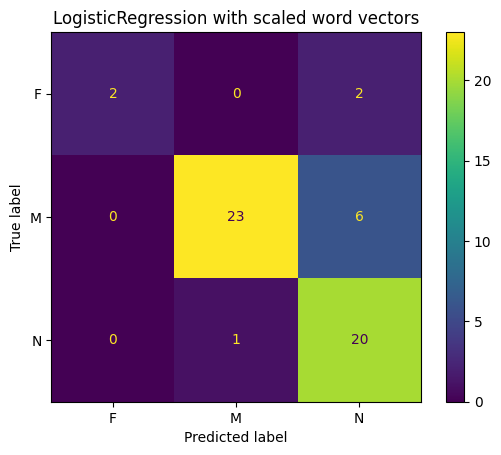

In [52]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.title("LogisticRegression with scaled word vectors")
plt.show()

In [53]:
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels_cb, labels=clf.classes_)

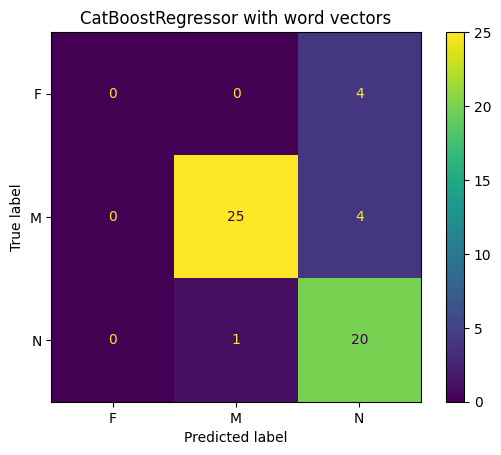

In [54]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.title("CatBoostRegressor with word vectors")
plt.show()

In [33]:
count_n = 0
count_m = 0
count_f = 0
for pred in predicted_labels_cb:
    if pred == "N":
        count_n += 1
    elif pred == "M":
        count_m += 1
    else:
        count_f += 1

print(count_f)
print(count_m)
print(count_n)

0
25
29


In [34]:
count_n = 0
count_m = 0
count_f = 0
for true in true_labels:
    if true == "N":
        count_n += 1
    elif true == "M":
        count_m += 1
    else:
        count_f += 1

print(count_f)
print(count_m)
print(count_n)



4
29
21


In [35]:
rounded_true = [round(s, 2) for s in true_male_shares]
rounded_pred = [round(s, 2) for s in male_share_predictions]

In [36]:
correct_labels_cb = []
for true, pred in zip(true_labels, predicted_labels_cb):
    if true == pred:
        correct_labels_cb.append("YES")
    else:
        correct_labels_cb.append("NO")

In [37]:
correct_labels_lr = []
for true, p in zip(true_labels, predicted_labels_lr):
    if true == p:
        correct_labels_lr.append("YES")
    else:
        correct_labels_lr.append("NO")

In [38]:
differences = []
for true, pred in zip(rounded_true, rounded_pred):
    differences.append(true - pred)

In [39]:
catboost_pred_true_df = pd.DataFrame(list(zip(rounded_true, rounded_pred, differences, true_labels, predicted_labels_cb, predicted_labels_lr, correct_labels_cb, correct_labels_lr)), columns=["True male share", "Predicted male share", "Difference", "True label", "Predicted label CatBoost", "Predicted label LogReg", "Correct label CatBoost", "Correct label LogReg"])
catboost_pred_true_df

,True male share,Predicted male share,Difference,True label,Predicted label CatBoost,Predicted label LogReg,Correct label CatBoost,Correct label LogReg
0,0.23,0.59,-0.36,F,N,F,NO,YES
1,1.00,1.00,0.00,M,M,M,YES,YES
2,0.98,0.96,0.02,M,M,M,YES,YES
3,0.27,0.61,-0.34,F,N,F,NO,YES
4,0.62,0.48,0.14,N,N,N,YES,YES
5,0.90,0.68,0.22,M,N,M,NO,YES
6,0.60,0.52,0.08,N,N,N,YES,YES
7,0.83,0.71,0.12,M,M,N,YES,NO
8,0.99,0.96,0.03,M,M,M,YES,YES
9,1.00,0.97,0.03,M,M,M,YES,YES


In [9]:
male_share = list(df["Male share (unknown gender included)"])
female_share = list(df["Female share (unknown gender included)"])
y_multi = list(zip(male_share, female_share))
y_multi

[(0.574, 0.37),
 (0.235, 0.753),
 (0.725, 0.255),
 (0.792, 0.188),
 (0.6, 0.375),
 (0.41, 0.553),
 (0.471, 0.52),
 (0.342, 0.613),
 (0.962, 0.029),
 (0.458, 0.521),
 (0.894, 0.082),
 (0.721, 0.26),
 (0.968, 0.016),
 (0.96, 0.035),
 (0.987, 0.0),
 (0.889, 0.111),
 (0.103, 0.897),
 (0.596, 0.386),
 (0.378, 0.545),
 (0.4, 0.6),
 (0.846, 0.154),
 (0.929, 0.071),
 (0.982, 0.005),
 (0.972, 0.028),
 (0.88, 0.065),
 (0.282, 0.705),
 (0.318, 0.677),
 (0.637, 0.357),
 (0.643, 0.357),
 (0.929, 0.071),
 (0.8, 0.2),
 (0.987, 0.0),
 (0.971, 0.029),
 (0.95, 0.031),
 (1.0, 0.0),
 (0.965, 0.009),
 (0.995, 0.005),
 (0.639, 0.329),
 (0.953, 0.016),
 (0.818, 0.152),
 (0.78, 0.198),
 (0.686, 0.296),
 (0.957, 0.032),
 (0.95, 0.01),
 (0.891, 0.096),
 (0.514, 0.448),
 (0.615, 0.369),
 (0.832, 0.15),
 (0.952, 0.036),
 (0.649, 0.339),
 (0.595, 0.381),
 (0.979, 0.018),
 (0.849, 0.144),
 (0.445, 0.545),
 (0.429, 0.571),
 (0.703, 0.243),
 (0.514, 0.462),
 (0.718, 0.239),
 (0.539, 0.435),
 (0.4, 0.6),
 (0.734, 0.25

In [12]:
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_embeddings, y_multi, test_size=0.3, random_state=428)

In [13]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 0.02, step=0.001)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['eval_metric'] = 'MultiRMSE'
    param['loss_function'] = 'MultiRMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = 1
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_emb_train, y_multi_train, early_stopping_rounds=100)
    loss = mean_squared_error(y_multi_test, regressor.predict(X_emb_test), squared=False)
    return loss

In [14]:
study = optuna.create_study()
study.optimize(objective, n_trials=500)

[I 2023-01-17 08:45:40,175] A new study created in memory with name: no-name-f593fda3-f4aa-4417-9d30-382a93759724
[I 2023-01-17 08:46:10,970] Trial 0 finished with value: 0.16924124413485625 and parameters: {'learning_rate': 0.005, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 4}. Best is trial 0 with value: 0.16924124413485625.
[W 2023-01-17 08:46:48,696] Trial 1 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\britt\AppData\Local\Temp\ipykernel_6864\3846898691.py", line 17, in objective
    regressor.fit(X_emb_train, y_multi_train, early_stopping_rounds=100)
  File "c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, t

KeyboardInterrupt: 

In [22]:
param = {}
param['learning_rate'] = 0.017
param['depth'] = 10
param['l2_leaf_reg'] = 3.0
param['min_child_samples'] = 32
param['grow_policy'] = 'Depthwise'
param['eval_metric'] = 'MultiRMSE'
param['loss_function'] = 'MultiRMSE'
param['od_type'] = 'iter'
param['od_wait'] = 20
param['random_state'] = 1
param['logging_level'] = 'Silent'

regressor = CatBoostRegressor(**param)

regressor.fit(X_multi_train, y_multi_train, early_stopping_rounds=100)

In [23]:
rmse = mean_squared_error(y_multi_test, regressor.predict(X_multi_test), squared=False)
mae = mean_absolute_error(y_multi_test, regressor.predict(X_multi_test))
r2 = r2_score(y_multi_test, regressor.predict(X_multi_test))

In [24]:
rmse

0.15400819281773748

In [25]:
mae

0.11656460089913179

In [26]:
r2

0.6195078502864197

In [27]:
multi_train_labels = []
for m_share, _ in y_multi_train:
    if m_share < 0.3:
        label = "F"
    elif m_share < 0.7:
        label = "N"
    else:
        label = "M"
    multi_train_labels.append(label)

In [28]:
multi_test_labels = []
for m_share, _ in y_multi_test:
    if m_share < 0.3:
        label = "F"
    elif m_share < 0.7:
        label = "N"
    else:
        label = "M"
    multi_test_labels.append(label)

In [30]:
cb_multi_predictions = regressor.predict(X_multi_test)

In [31]:
predicted_labels_male_multi_cb = []
for m_share, _ in cb_multi_predictions:
    if m_share < 0.3:
        label = "F"
    elif m_share < 0.7:
        label = "N"
    else:
        label = "M"
    predicted_labels_male_multi_cb.append(label)

In [32]:
predicted_labels_female_multi_cb = []
for _, f_share in cb_multi_predictions:
    if f_share < 0.3:
        label = "M"
    elif m_share < 0.7:
        label = "N"
    else:
        label = "F"
    predicted_labels_female_multi_cb.append(label)

In [33]:
list(zip(predicted_labels_male_multi_cb, predicted_labels_female_multi_cb))

[('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'M'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('M', 'M'),
 ('N', 'N')]

In [34]:
acc = accuracy_score(predicted_labels_male_multi_cb, multi_test_labels)
recall = recall_score(predicted_labels_male_multi_cb, multi_test_labels, average="weighted")
precision = precision_score(predicted_labels_male_multi_cb, multi_test_labels, average="weighted")
f1 = f1_score(predicted_labels_male_multi_cb, multi_test_labels, average="weighted")

c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
print("Classification by converting predicted shares from CatBoostRegressor (multioutput) to labels:")
print(f"Score: {round(acc, 3)}")
print(f"F1: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")

Classification by converting predicted shares from CatBoostRegressor (multioutput) to labels:
Score: 0.815
F1: 0.84
Recall: 0.815
Precision: 0.912


In [40]:
cm = confusion_matrix(y_true=multi_test_labels, y_pred=predicted_labels_male_multi_cb, labels=clf.classes_)

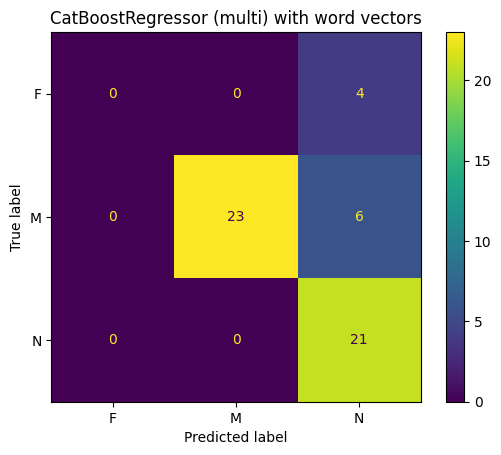

In [41]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.title("CatBoostRegressor (multi) with word vectors")
plt.show()